In [ ]:
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import pandas as pd

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (Dataset, TensorDataset, DataLoader, Subset)

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [ ]:
# Dados
PETR4SA = 'PETR4.SA'
START_DATE = '2022-01-01'
END_DATE = '2023-01-31'

In [ ]:
# Funções

# Accumulation / Distribution Oscillation
def ad_oscillator(closing, low, high, volume):
  return ((closing-low) - (high - closing)) * volume / (high-low)

# Larry William's R%
def larry_william_rperc(closing, low, high):
  if (high - low == 0):
    return -100
  return (high - closing) * (-100) / (high - low)

def momentum(closing, past_closing):
  return closing - past_closing

# Relative Strength Index
def rsi(series):
  temp = np.NaN
  Up = 0
  Down = 0
  n = len(series)
  for x in series:
    if temp == np.NaN:
      temp = x
      if x > 0:
        Up = x
      elif x < 0:
        Down = x
    else:
      if x > temp:
        Up = Up + 1
      elif x < temp:
        Down = Down + 1
      temp = x
  if Down == 0 or n == 0:
    return 100
  return (1-(Up/n)/(Down/n)) and (100 - (100/(1-(Up/n)/(Down/n)))) or 100

# Stochastic K%
def stochastic_k(closing, min, max):
  if (max - min == 0):
    return 0
  return 100 * (closing - min) / (max - min)

# Stochastic D% is the 3-day SMA of K%

# Commodity Channel Index
def cci(typical_price, moving_average, mean_deviation):
  if (mean_deviation == 0):
    return 0
  return (typical_price - moving_average) / (0.015 * mean_deviation)

In [ ]:
# Faça download da série temporal que desejamos estudar
PETR4SA_df = yf.download(PETR4SA,
                 start = START_DATE,
                 end = END_DATE,
                 progress = False)

In [ ]:
PETR4SA_df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

                 Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2022-01-03  28.540001  29.219999  28.530001  29.090000  14.200678  52704700   
2022-01-04  29.160000  29.400000  28.910000  29.200001  14.254376  51739200   
2022-01-05  29.190001  29.270000  27.940001  28.070000  13.702752  78459800   
2022-01-06  28.290001  28.650000  27.840000  28.049999  13.692988  61163100   
2022-01-07  28.110001  28.290001  27.820000  28.180000  13.756451  47507600   
...               ...        ...        ...        ...        ...       ...   
2023-01-24  27.469999  27.530001  26.370001  26.600000  22.219486  65794000   
2023-01-25  26.549999  27.080000  26.010000  26.940001  22.503494  51832900   
2023-01-26  27.090000  27.200001  25.799999  26.250000  21.927124  73344800   
2023-01-27  26.180000  26.230000  25.440001  25.620001  21.400873  47681900   
2023-01-30  25.850000  26.070000  25.510000  25.7500

<Axes: xlabel='Date'>

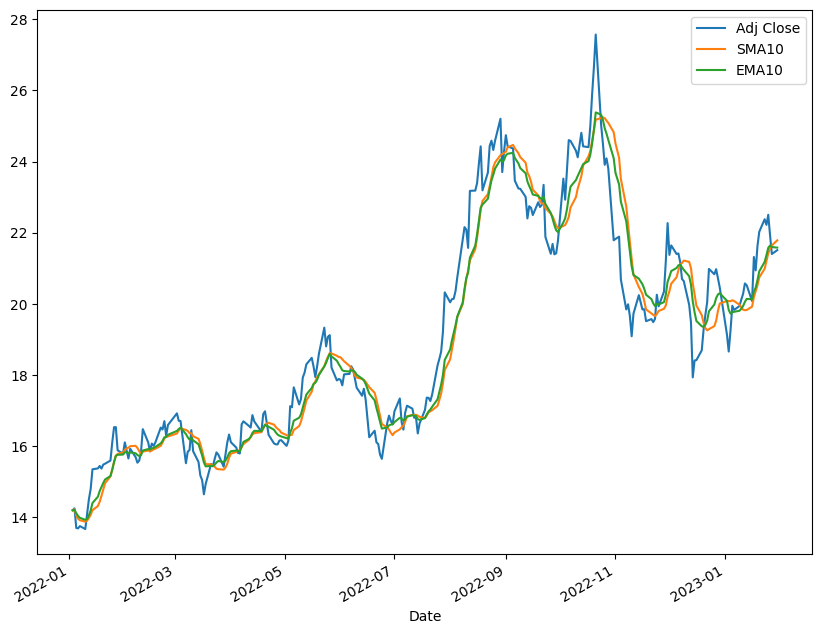

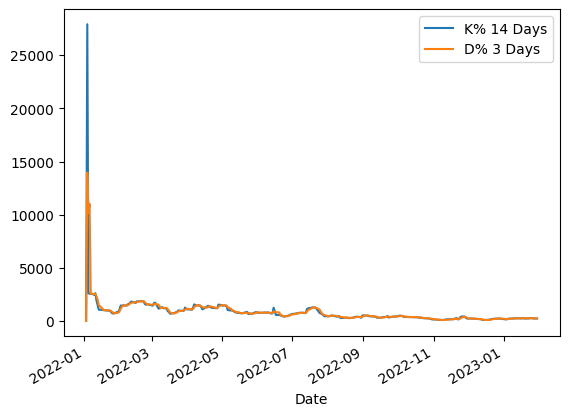

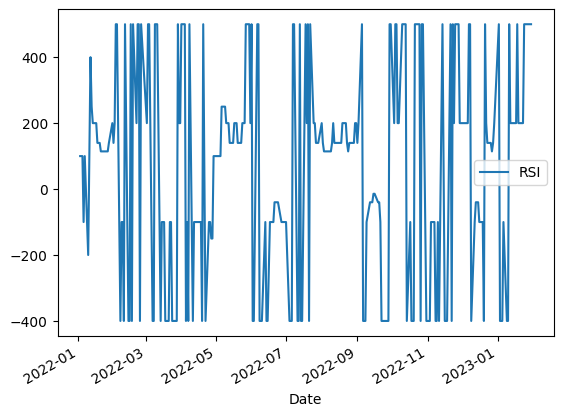

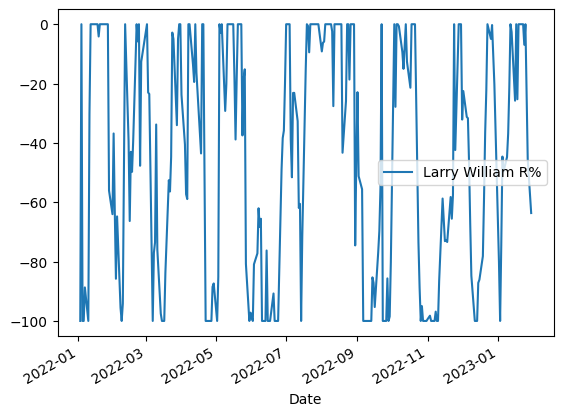

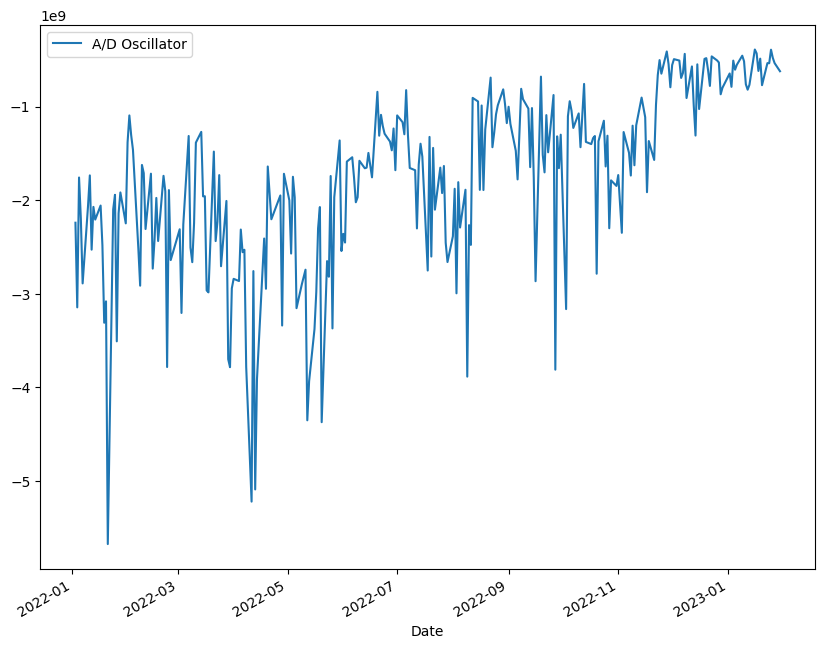

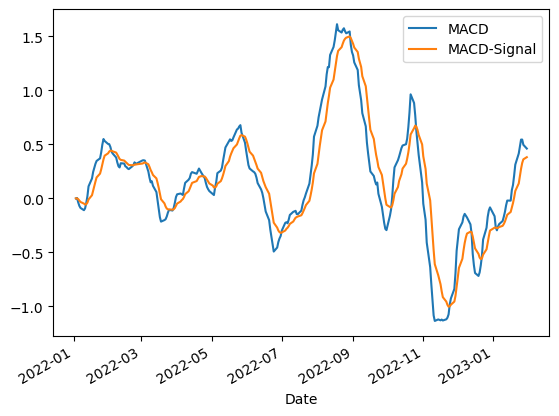

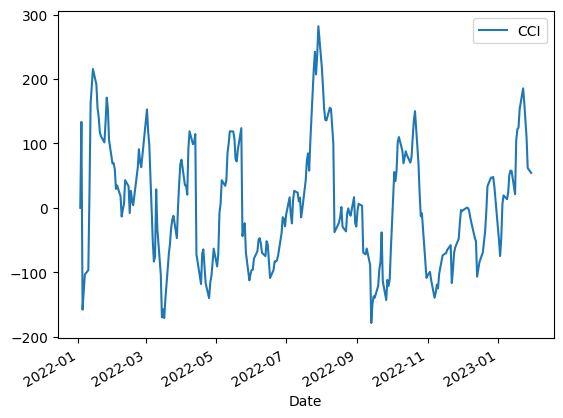

In [ ]:
from sklearn import preprocessing

def scale_values(x):
  scaler = preprocessing.MinMaxScaler()
  x_scaled = scaler.fit_transform(x)
  return x_scaled, scaler

def add_metrics(df):
  df['SMA10'] = df['Adj Close'].rolling(10, min_periods=1).mean()
  df['EMA10'] = df['Adj Close'].ewm(span=10, adjust=False).mean()
  df['Max10Past'] = df['Adj Close'].rolling(10, min_periods=1).max()
  df['Min10Past'] = df['Adj Close'].rolling(10, min_periods=1).min()
  df['Max14Past'] = df['Adj Close'].rolling(14, min_periods=1).max()
  df['Min14Past'] = df['Adj Close'].rolling(14, min_periods=1).min()
  # Stochasting K% for 14 days
  df['K% 14 Days'] = df.apply(lambda x : stochastic_k(x['Close'], x['Min14Past'], x['Max14Past']), axis=1)
  del df['Max14Past']
  del df['Min14Past']
  # Stochasting D% for 3 days
  df['D% 3 Days'] = df['K% 14 Days'].rolling(3, min_periods=1).mean()
  # A/D Oscillator
  df['A/D Oscillator'] = df.apply(lambda x : ad_oscillator(x['Adj Close'], x['Low'], x['High'], x['Volume']), axis=1)
  # Larry William's R%
  df['Larry William R%'] = df.apply(lambda x : larry_william_rperc(x['Adj Close'], x['Min10Past'], x['Max10Past']), axis=1)
  # Relative Strength Index
  df['RSI'] = df['Adj Close'].rolling(10, min_periods=1).apply(rsi)
  # Moving Average Convergence Divergence for 9 days
  df['EMA12'] = df['Adj Close'].ewm(span=12, adjust=False).mean()
  df['EMA26'] = df['Adj Close'].ewm(span=26, adjust=False).mean()
  df['MACD'] = df.apply(lambda x: x['EMA12'] - x['EMA26'], axis=1)
  df['MACD-Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
  del df['EMA12']
  del df['EMA26']
  # Commodity Channel Index for 20 days
  df['Typical Price'] = df.apply(lambda x : (x['High'] + x['Close'] + x['Low']) / 3, axis=1)
  df['Typical Price MA'] = df['Typical Price'].rolling(20, min_periods=1).mean()
  df['Deviation'] = df.apply(lambda x : abs(x['Typical Price'] - x['Typical Price MA']), axis=1)
  df['Mean Deviation'] = df['Deviation'].rolling(20, min_periods=1).mean()
  df['CCI'] = df.apply(lambda x : cci(x['Typical Price'], x['Typical Price MA'], x['Mean Deviation']), axis=1)
  del df['Typical Price']
  del df['Typical Price MA']
  del df['Deviation']
  del df['Mean Deviation']
  return df
# Aqui criamos varios indicadores a serem utilizados posteriormente como entrada pela rede neural
PETR4_prices = PETR4SA_df['Adj Close'].values

PETR4SA_norm = PETR4SA_df.copy(deep=True)


PETR4SA_norm['High'], scaler = scale_values(PETR4SA_norm['High'].values.reshape(-1,1))
PETR4SA_norm['Low'], scaler = scale_values(PETR4SA_norm['Low'].values.reshape(-1,1))
PETR4SA_norm['Close'], scaler = scale_values(PETR4SA_norm['Close'].values.reshape(-1,1))
PETR4SA_norm['Adj Close'], scaler = scale_values(PETR4SA_norm['Adj Close'].values.reshape(-1,1))

PETR4SA_df = add_metrics(PETR4SA_df)

print(PETR4SA_df)
#print(PETR4SA_norm)

PETR4SA_df[['Adj Close', 'SMA10', 'EMA10']].plot(figsize=(10,8))
PETR4SA_df[['K% 14 Days', 'D% 3 Days']].plot()
PETR4SA_df[['RSI']].plot()
PETR4SA_df[['Larry William R%']].plot()
PETR4SA_df[['A/D Oscillator']].plot(figsize=(10,8))
PETR4SA_df[['MACD', 'MACD-Signal']].plot()
PETR4SA_df[['CCI']].plot()

(array([-60, -59, -58, -57, -56, -55, -54, -53, -52, -51, -50, -49, -48,
        -47, -46, -45, -44, -43, -42, -41, -40, -39, -38, -37, -36, -35,
        -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22,
        -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,
         -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,
          5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
         18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
         31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
         44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
         57,  58,  59,  60]),
 array([0.78790446, 0.79137067, 0.79460393, 0.7979878 , 0.8013209 ,
        0.80445774, 0.80768993, 0.81108374, 0.81434713, 0.81749165,
        0.82064104, 0.82386662, 0.82717435, 0.83052802, 0.83417116,
        0.8376534 , 0.84115799, 0.8448255 , 0.84892621, 0.85282409,
        0.85683705, 0.8608084 , 0.8646761

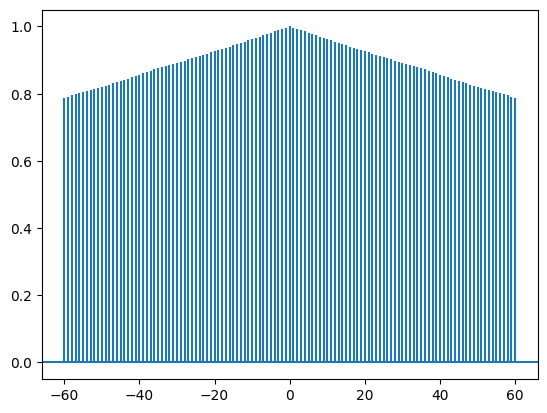

In [ ]:
# Plotamos a correlação dos dados com si mesmos para estimarmos quantos dias podemos correlacionar a um valor futuro
plt.xcorr(PETR4_prices, PETR4_prices, maxlags = 60)

In [ ]:
df_size = len(PETR4SA_df)
print(df_size)

271


In [ ]:
# Dados de treino/validação/teste
VALIDATION_SIZE = 30
TEST_SIZE = 30
BATCH_SIZE = 5

In [ ]:
# Esta funcao organizara os indicadores previamente definidos junto do preco de fechamento ajustado para um dado dia N. Queremos prever o dia N+1.
def organize_indicators_ma(df):
  X, y = [], []
  df_pred = df.shift(periods=-1)
  for index, row in df.iterrows():
    X.append([row['Adj Close'], row['SMA10'], row['EMA10']])
    #, row['K% 14 Days'], row['D% 3 Days'], row['A/D Oscillator'], row['Larry William R%'], row['MACD'], row['MACD-Signal'], row['RSI'], row['CCI']
  y = df_pred['Adj Close'].values
  X = X[:-1]
  y = y[:-1]
  return np.array(X), np.array(y)

def organize_indicators_all(df):
  X, y = [], []
  df_pred = df.shift(periods=-1)
  for index, row in df.iterrows():
    X.append([row['Adj Close'], row['SMA10'], row['EMA10'], row['K% 14 Days'], row['D% 3 Days'], row['A/D Oscillator'], row['Larry William R%'], row['MACD'], row['MACD-Signal'], row['RSI'], row['CCI']])
    #
  y = df_pred['Adj Close'].values
  X = X[:-1]
  y = y[:-1]
  return np.array(X), np.array(y)

def prepare_input_data(series, step_size):
  X, y = [], []
  for step in range(len(series) - step_size):
    end_step = step + step_size
    X.append(series[step:end_step])
    y.append(series[end_step])
  return np.array(X), np.array(y)

In [ ]:
X = PETR4SA_df['Adj Close'].values

In [ ]:
valid_ind = len(X) - VALIDATION_SIZE - TEST_SIZE
test_ind = len(X) - TEST_SIZE

In [ ]:
# ARIMA como benchmark
from statsmodels.tsa.arima.model import ARIMA

train_ARIMA = X[0:valid_ind]
test_ARIMA = X[valid_ind:]
print(len(train_ARIMA))
print(len(test_ARIMA))
series_ARIMA = [x for x in train_ARIMA]
pred_ARIMA = list()
for i in range(len(test_ARIMA)):
  model = ARIMA(series_ARIMA, order=(10,1,0))
  model_fit = model.fit()
  output = model_fit.forecast()
  y_pred = output[0]
  pred_ARIMA.append(y_pred)
  expected = test_ARIMA[i]
  series_ARIMA.append(expected)
  #print(f'Previsto:{y_pred} Esperado:{expected}')

211
60


MSE do Teste: 0.317 RMSE do Teste: 0.563 MAPE do Teste: 0.022


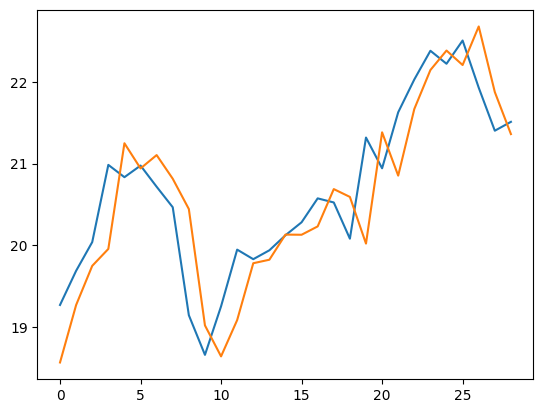

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt

MSE_ARIMA = mean_squared_error(test_ARIMA[31:], pred_ARIMA[31:])
MAPE_ARIMA = mean_absolute_percentage_error(test_ARIMA[31:], pred_ARIMA[31:])
print(f'MSE do Teste: {MSE_ARIMA:.3f} RMSE do Teste: {sqrt(MSE_ARIMA):.3f} MAPE do Teste: {MAPE_ARIMA:.3f}')

plt.plot(test_ARIMA[31:])
plt.plot(pred_ARIMA[31:])
plt.show()

In [ ]:
X, y = organize_indicators_ma(PETR4SA_df)

In [ ]:
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float().unsqueeze(dim=1)

dataset = TensorDataset(X_tensor, y_tensor)

train_dataset = Subset(dataset, list(range(valid_ind)))
valid_dataset = Subset(dataset, list(range(valid_ind, test_ind)))
test_dataset = Subset(dataset, list(range(test_ind, len(X))))

train_loader = DataLoader(dataset = train_dataset,
                          batch_size = BATCH_SIZE)
valid_loader = DataLoader(dataset = valid_dataset,
                          batch_size = BATCH_SIZE)
test_loader = DataLoader(dataset = test_dataset,
                          batch_size = BATCH_SIZE)
data_loader = DataLoader(dataset = dataset,
                          batch_size = BATCH_SIZE)
next(iter(train_loader))[0]

tensor([[14.2007, 14.2007, 14.2007],
        [14.2544, 14.2275, 14.2104],
        [13.7028, 14.0526, 14.1181],
        [13.6930, 13.9627, 14.0408],
        [13.7565, 13.9214, 13.9891]])

In [ ]:
LAYER_1 = 16
LAYER_2 = 8
# Perceptron de multiplas camadas
class MLP(nn.Module):
  def __init__(self, input_size):
    super(MLP, self).__init__()
    self.input = input_size
    self.fc1 = nn.Linear(input_size, self.input * LAYER_1)
    self.fc2 = nn.Linear(self.input * LAYER_1, self.input * LAYER_2)
    self.fc3 = nn.Linear(self.input * LAYER_2, self.input * LAYER_2)
    self.fc4 = nn.Linear(self.input * LAYER_2, 1)
    self.dropout = nn.Dropout(p=0.2)
  def forward(self, x):
    x = x.view(-1, self.input)
    x = torch.relu(self.fc1(x))
    x = x + (0.1**0.5)*torch.randn(self.input * LAYER_1)
    #x = self.dropout(x)
    x = torch.relu(self.fc2(x))
    #x = self.dropout(x)
    x = torch.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
torch.manual_seed(144)

model_mlp = MLP(len(X[0])).to(device)
loss_fn = nn.MSELoss()
optimizer_mlp = optim.Adam(model_mlp.parameters(), lr = 0.01)

In [ ]:
# Treinamento / validacao da MLP
N_EPOCHS = 1000
train_losses, valid_losses = [], []
best_epoch = 0
for epoch in range(N_EPOCHS):
  running_loss_train = 0
  running_loss_valid = 0

  model_mlp.train()
  for X_batch, y_batch in train_loader:
    optimizer_mlp.zero_grad()
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    y_pred = model_mlp(X_batch)
    loss = loss_fn(y_pred, y_batch)
    loss.backward()
    optimizer_mlp.step()
    running_loss_train += loss.item() * X_batch.size(0)
    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_losses.append(epoch_loss_train)
  with torch.no_grad():
    model_mlp.eval()
    for X_val, y_val in valid_loader:
      X_val = X_val.to(device)
      y_val = y_val.to(device)
      y_pred = model_mlp(X_val)
      loss = loss_fn(y_val, y_pred)
      running_loss_valid += loss.item() * X_val.size(0)
      epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
      if epoch > 0 and epoch_loss_valid < min(valid_losses):
        best_epoch = epoch
        torch.save(model_mlp.state_dict(), './best_mlp.pth')
      valid_losses.append(epoch_loss_valid)
  if (epoch+1) % 50 == 0:
    print(f"[{(epoch+1)}] Training loss: {epoch_loss_train:.4f} Validation loss: {epoch_loss_valid:.4f}")
    print(f"Lowest loss in epoch: {best_epoch}")

[50] Training loss: 1.2639 Validation loss: 0.7700
Lowest loss in epoch: 49
[100] Training loss: 0.9830 Validation loss: 0.9003
Lowest loss in epoch: 49
[150] Training loss: 0.6851 Validation loss: 0.7746
Lowest loss in epoch: 145
[200] Training loss: 0.7286 Validation loss: 0.8898
Lowest loss in epoch: 178
[250] Training loss: 0.5787 Validation loss: 0.3213
Lowest loss in epoch: 241
[300] Training loss: 0.7781 Validation loss: 0.2941
Lowest loss in epoch: 252
[350] Training loss: 0.7834 Validation loss: 0.7399
Lowest loss in epoch: 302
[400] Training loss: 1.6305 Validation loss: 1.0337
Lowest loss in epoch: 387
[450] Training loss: 3.3002 Validation loss: 3.7237
Lowest loss in epoch: 406
[500] Training loss: 9.6135 Validation loss: 4.3124
Lowest loss in epoch: 458
[550] Training loss: 5.6179 Validation loss: 5.5850
Lowest loss in epoch: 458
[600] Training loss: 4.3562 Validation loss: 8.0262
Lowest loss in epoch: 458
[650] Training loss: 4.2215 Validation loss: 7.3183
Lowest loss in 

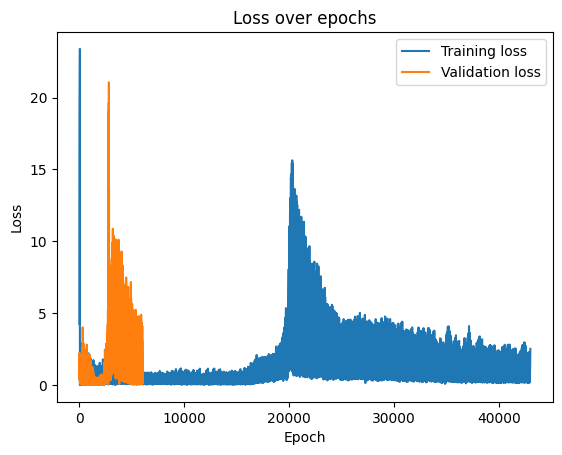

In [ ]:
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)
fig, ax = plt.subplots()
ax.plot(train_losses, label='Training loss')
ax.plot(valid_losses, label='Validation loss')
ax.set(title="Loss over epochs",
       xlabel = "Epoch",
       ylabel = "Loss")
ax.legend()

In [ ]:
state_dict = torch.load('best_mlp.pth')
model_mlp.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
y_pred_mlp, y_test_mlp = [], []
with torch.no_grad():
  model_mlp.eval()
  for X_val, y_val in test_loader:
    X_val = X_val.to(device)
    y_pred_mlp.append(model_mlp(X_val))
    y_test_mlp.append(y_val)
y_pred_mlp = torch.cat(y_pred_mlp).numpy()
scaler.inverse_transform(y_pred_mlp).flatten()
y_test_mlp = torch.cat(y_test_mlp).numpy()
scaler.inverse_transform(y_test_mlp).flatten()

array([281.43356, 287.23676, 292.11145, 305.22675, 303.13757, 305.11066,
       301.51266, 298.03076, 279.6926 , 272.96088, 281.20142, 290.83478,
       289.20987, 290.71872, 293.27213, 295.47736, 299.53958, 298.8432 ,
       292.6918 , 309.86932, 304.64642, 314.16364, 319.73474, 324.60944,
       322.40424, 326.3504 , 318.34198, 311.02994, 312.53876],
      dtype=float32)

Forecasted MSE: 0.502; RMSE: 0.708; MAPE: 0.028


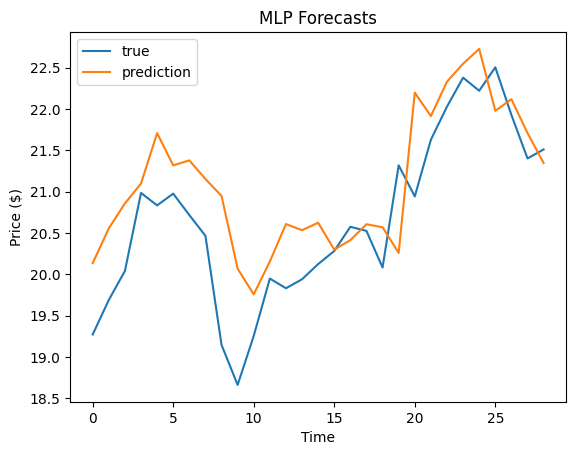

In [ ]:
mlp_mse = mean_squared_error(y_test_mlp, y_pred_mlp)
mlp_rmse = np.sqrt(mlp_mse)
mlp_mape = mean_absolute_percentage_error(y_test_mlp, y_pred_mlp)
print(f"Forecasted MSE: {mlp_mse:.3f}; RMSE: {mlp_rmse:.3f}; MAPE: {mlp_mape:.3f}")

fix, ax = plt.subplots()

ax.plot(y_test_mlp, label='true')
ax.plot(y_pred_mlp, label='prediction')

ax.set(title='MLP Forecasts',
       xlabel='Time',
       ylabel='Price ($)')
ax.legend()

In [ ]:
y_pred_mlp_full, y_test_mlp_full = [], []
with torch.no_grad():
  model_mlp.eval()
  for X_val, y_val in data_loader:
    X_val = X_val.to(device)
    y_pred_mlp_full.append(model_mlp(X_val))
    y_test_mlp_full.append(y_val)
y_pred_mlp_full = torch.cat(y_pred_mlp_full).numpy()
scaler.inverse_transform(y_pred_mlp_full).flatten()
y_test_mlp_full = torch.cat(y_test_mlp_full).numpy()
scaler.inverse_transform(y_test_mlp_full).flatten()

array([211.73225, 204.06766, 203.93199, 204.81378, 203.66069, 209.29044,
       215.25934, 219.32903, 226.99367, 227.33276, 228.28238, 227.26497,
       228.825  , 229.16417, 230.38506, 237.43924, 243.40814, 243.47595,
       234.38693, 233.09818, 237.50702, 234.25128, 231.19897, 234.99738,
       231.74162, 229.57114, 230.38506, 233.70862, 242.662  , 237.50702,
       233.97995, 237.03224, 236.15045, 237.50702, 243.27245, 242.52637,
       245.78209, 240.15233, 244.28989, 248.83437, 245.91776, 245.84991,
       229.3676 , 233.84428, 234.5226 , 242.25502, 234.04779, 229.84242,
       224.61966, 222.78827, 217.22636, 221.29605, 229.09633, 228.14673,
       231.06334, 233.57298, 232.75903, 228.01108, 232.75903, 237.43924,
       240.55933, 237.57487, 235.47218, 233.36948, 233.16603, 244.56116,
       245.71428, 243.95073, 243.27245, 248.15607, 245.70918, 241.62798,
       248.52896, 249.642  , 240.44072, 237.10155, 236.73051, 236.73051,
       238.2146 , 238.36304, 236.13689, 238.14043, 

Forecasted MSE: 0.50; RMSE: 0.71; MAPE: 0.03


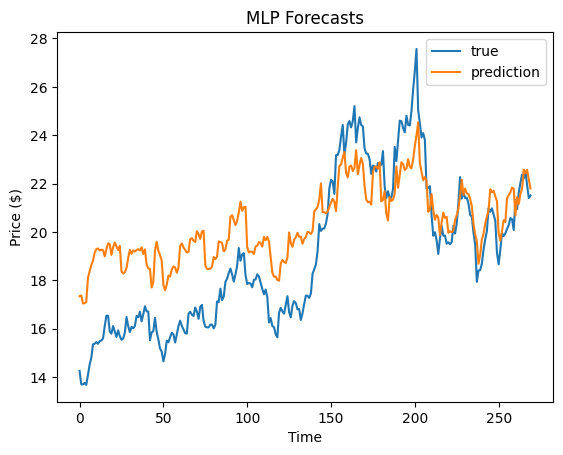

In [ ]:
mlp_mse_full = mean_squared_error(y_test_mlp_full, y_pred_mlp_full)
mlp_rmse_full = np.sqrt(mlp_mse_full)
mlp_mape_full = mean_absolute_percentage_error(y_test_mlp_full, y_pred_mlp_full)
print(f"Forecasted MSE: {mlp_mse:.3f}; RMSE: {mlp_rmse:.3f}; MAPE: {mlp_mape:.3f}")

fix, ax = plt.subplots()

ax.plot(y_test_mlp_full, label='true')
ax.plot(y_pred_mlp_full, label='prediction')

ax.set(title='MLP Forecasts',
       xlabel='Time',
       ylabel='Price ($)')
ax.legend()

In [ ]:
LAYER_1 = 25
class LSTM(nn.Module):
  def __init__(self, input_size):
    super(LSTM, self).__init__()
    self.lstm = nn.LSTM(input_size, input_size * LAYER_1, 1, batch_first=True)
    self.dropout = nn.Dropout(p=0.2)
    self.lstm_2 = nn.LSTM(input_size * LAYER_1, input_size * LAYER_1, 1, batch_first=True)
    self.fc1 = nn.Linear(input_size * LAYER_1, 1)
  def forward(self, x):
    x, _ = self.lstm(x)
    x = self.dropout(x)
    x, _ = self.lstm_2(x)
    x = self.dropout(x)
    x = self.fc1(x[:,-1,:])
    return x

In [ ]:
# Preparar os dados para a LSTM
X, y = organize_indicators_all(PETR4SA_df)

X_tensor = torch.from_numpy(X).float().reshape(X.shape[0], X.shape[1], 1)
y_tensor = torch.from_numpy(y).float().reshape(X.shape[0], 1)

dataset = TensorDataset(X_tensor, y_tensor)

train_dataset = Subset(dataset, list(range(valid_ind)))
valid_dataset = Subset(dataset, list(range(valid_ind, test_ind)))
test_dataset = Subset(dataset, list(range(test_ind, len(X))))

train_loader = DataLoader(dataset = train_dataset,
                          batch_size = BATCH_SIZE)
valid_loader = DataLoader(dataset = valid_dataset,
                          batch_size = BATCH_SIZE)
test_loader = DataLoader(dataset = test_dataset,
                          batch_size = BATCH_SIZE)
data_loader = DataLoader(dataset = dataset,
                          batch_size = BATCH_SIZE)
#next(iter(train_loader))[0]

In [ ]:
# Preparar a LSTM

model_lstm = LSTM(1).to(device)
loss_fn = nn.MSELoss()
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr = 0.001)

In [ ]:
# Treino da LSTM
N_EPOCHS = 1000
train_losses, valid_losses = [], []
best_epoch = 0
# Treinamento / validacao
for epoch in range(N_EPOCHS):
  running_loss_train = 0
  running_loss_valid = 0

  model_lstm.train()
  for X_batch, y_batch in train_loader:
    optimizer_lstm.zero_grad()
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    y_pred = model_lstm(X_batch)
    loss = loss_fn(y_pred, y_batch)
    loss.backward()
    optimizer_lstm.step()
    running_loss_train += loss.item() * X_batch.size(0)
    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_losses.append(epoch_loss_train)
  with torch.no_grad():
    model_lstm.eval()
    for X_val, y_val in valid_loader:
      X_val = X_val.to(device)
      y_val = y_val.to(device)
      y_pred = model_lstm(X_val)
      loss = loss_fn(y_val, y_pred)
      running_loss_valid += loss.item() * X_val.size(0)
      epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
      if epoch > 0 and epoch_loss_valid < min(valid_losses):
        best_epoch = epoch
        torch.save(model_lstm.state_dict(), './best_lstm.pth')
      valid_losses.append(epoch_loss_valid)
  if (epoch+1) % 50 == 0:
    print(f"[{(epoch+1)}] Training loss: {epoch_loss_train:.5f} Validation loss: {epoch_loss_valid:.5f}")
    print(f"Lowest loss in epoch: {best_epoch}")

[50] Training loss: 14.77028 Validation loss: 3.23005
Lowest loss in epoch: 46
[100] Training loss: 17.18816 Validation loss: 3.60270
Lowest loss in epoch: 57
[150] Training loss: 12.81348 Validation loss: 9.51502
Lowest loss in epoch: 57
[200] Training loss: 10.47130 Validation loss: 17.55432
Lowest loss in epoch: 57
[250] Training loss: 9.79120 Validation loss: 19.44687
Lowest loss in epoch: 57
[300] Training loss: 6.81490 Validation loss: 16.00459
Lowest loss in epoch: 57
[350] Training loss: 4.92137 Validation loss: 2.49740
Lowest loss in epoch: 349
[400] Training loss: 3.94929 Validation loss: 1.15917
Lowest loss in epoch: 386
[450] Training loss: 3.60695 Validation loss: 1.09229
Lowest loss in epoch: 386
[500] Training loss: 4.36542 Validation loss: 2.76140
Lowest loss in epoch: 386
[550] Training loss: 3.43376 Validation loss: 0.77929
Lowest loss in epoch: 386
[600] Training loss: 3.21794 Validation loss: 1.01611
Lowest loss in epoch: 386
[650] Training loss: 3.54610 Validation 

In [ ]:
state_dict = torch.load('best_lstm.pth')
model_lstm.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
y_pred_lstm, y_test_lstm = [], []
with torch.no_grad():
  model_lstm.eval()
  for X_val, y_val in test_loader:
    X_val = X_val.to(device)
    y_pred_lstm.append(model_lstm(X_val))
    y_test_lstm.append(y_val)
y_pred_lstm = torch.cat(y_pred_lstm).numpy().flatten()
y_test_lstm = torch.cat(y_test_lstm).numpy().flatten()

Forecasted MSE: 2.4248; RMSE: 1.5572; MAPE: 0.0626


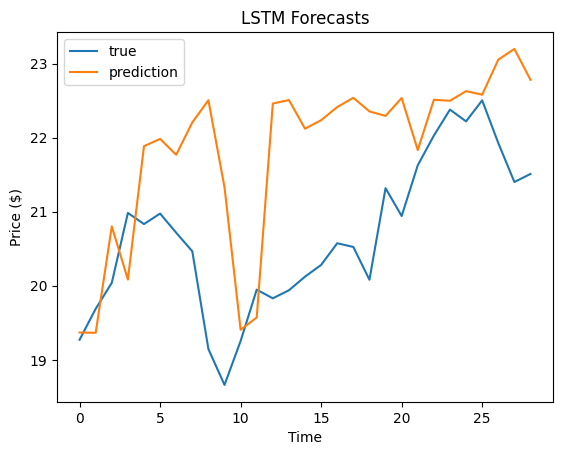

In [ ]:
lstm_mse = mean_squared_error(y_test_lstm, y_pred_lstm)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mape = mean_absolute_percentage_error(y_test_lstm, y_pred_lstm)
print(f"Forecasted MSE: {lstm_mse:.4f}; RMSE: {lstm_rmse:.4f}; MAPE: {lstm_mape:.4f}")

fix, ax = plt.subplots()

ax.plot(y_test_lstm, label='true')
ax.plot(y_pred_lstm, label='prediction')

ax.set(title='LSTM Forecasts',
       xlabel='Time',
       ylabel='Price ($)')
ax.legend()

In [ ]:
y_pred_lstm_full, y_test_lstm_full = [], []
with torch.no_grad():
  model_lstm.eval()
  for X_val, y_val in data_loader:
    X_val = X_val.to(device)
    y_pred_lstm_full.append(model_lstm(X_val))
    y_test_lstm_full.append(y_val)
y_pred_lstm_full = torch.cat(y_pred_lstm_full).numpy().flatten()
y_test_lstm_full = torch.cat(y_test_lstm_full).numpy().flatten()

Forecasted MSE: 2.4248; RMSE: 1.5572; MAPE: 0.0626


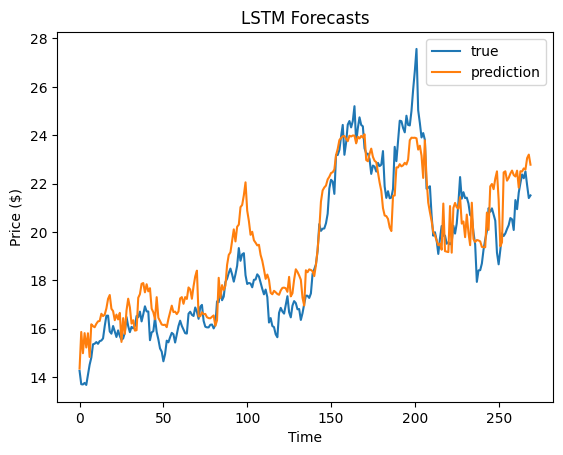

In [ ]:
lstm_mse_full = mean_squared_error(y_test_lstm_full, y_pred_lstm_full)
lstm_rmse_full = np.sqrt(lstm_mse_full)
lstm_mape_full = mean_absolute_percentage_error(y_test_lstm_full, y_pred_lstm_full)
print(f"Forecasted MSE: {lstm_mse:.4f}; RMSE: {lstm_rmse:.4f}; MAPE: {lstm_mape:.4f}")

fix, ax = plt.subplots()

ax.plot(y_test_lstm_full, label='true')
ax.plot(y_pred_lstm_full, label='prediction')

ax.set(title='LSTM Forecasts',
       xlabel='Time',
       ylabel='Price ($)')
ax.legend()

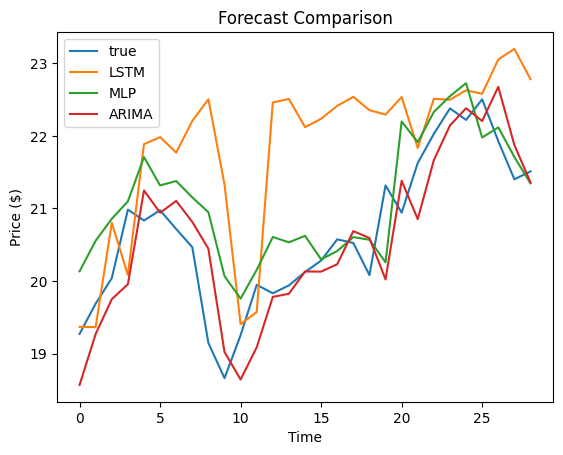

In [ ]:
fix, ax = plt.subplots()

ax.plot(y_test_lstm, label='true')
ax.plot(y_pred_lstm, label='LSTM')
ax.plot(y_pred_mlp, label='MLP')
ax.plot(pred_ARIMA[31:], label='ARIMA')

ax.set(title='Forecast Comparison',
       xlabel='Time',
       ylabel='Price ($)')
ax.legend()